In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import processing
from utils import utils

from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import LSTM, GRU, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, TimeDistributed
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (18,10)

In [4]:
kld = pd.read_csv('../data/processed/kolding_features.csv', index_col='Datetime', parse_dates=['Datetime'])
stb = pd.read_csv('../data/processed/kolding_features.csv', index_col='Datetime', parse_dates=['Datetime'])

#### Choose Features

In [4]:
kld.columns

Index(['Value', 'sunshine_mins', 'airtemp_c', 'humidity_pct', 'windspeed_mps',
       'precip_mins', 'precip_mm', 'daylength_hrs', 'wkdy', 'wkdy_sin',
       'wkdy_cos', 'wknd', 'qrtr', 'qrtr_sin', 'qrtr_cos'],
      dtype='object')

In [5]:
kld = kld[['Value', 'sunshine_mins', 'airtemp_c', 'daylength_hrs', 'wkdy_sin','wkdy_cos','wknd','qrtr_sin','qrtr_cos']]
stb = stb[['Value', 'sunshine_mins', 'airtemp_c', 'daylength_hrs', 'wkdy_sin','wkdy_cos','wknd','qrtr_sin','qrtr_cos']]

In [6]:
kld.head()

,Value,sunshine_mins,airtemp_c,daylength_hrs,wkdy_sin,wkdy_cos,wknd,qrtr_sin,qrtr_cos
Datetime,,,,,,,,,
2019-01-01 00:00:00,116.322,0.0,7.850000,7.148307,0.781831,0.62349,0,1.0,6.123234e-17
2019-01-01 01:00:00,102.681,0.0,7.883333,7.148307,0.781831,0.62349,0,1.0,6.123234e-17
2019-01-01 02:00:00,96.379,0.0,7.850000,7.148307,0.781831,0.62349,0,1.0,6.123234e-17
2019-01-01 03:00:00,85.352,0.0,7.983333,7.148307,0.781831,0.62349,0,1.0,6.123234e-17
2019-01-01 04:00:00,74.842,0.0,8.166667,7.148307,0.781831,0.62349,0,1.0,6.123234e-17


In [11]:
# Processing Parameters
split = 0.80 # split percentage for training data
steps = 1 # timesteps: 1 hour

lookback = 24 * 30 # the number of hours in the past the model is shown
horizon = 1 # the target hour in the future we want to predict 1 hour ahead

# Training parameters
batch_size = 256
epochs = 50
lr = 0.001

In [13]:
# Create Train, Val, and Test Sets
kld_train, kld_val, kld_test = processing.create_datasets(kld, split=split, steps=steps, lookback=lookback,
                                                          horizon=horizon, batch_size=batch_size, scaler='standard')
stb_train, stb_val, stb_test = processing.create_datasets(stb, split=split, steps=steps, lookback=lookback,
                                                          horizon=horizon, batch_size=batch_size, scaler='standard')

In [14]:
for batch in kld_train.take(1):
    inputs, targets = batch
    
print(f"Input Shape: {inputs.numpy().shape}")
print(f"Target Shape: {targets.numpy().shape}")

Input Shape: (256, 720, 9)
Target Shape: (256, 1)


In [15]:
hybrid = Sequential()

hybrid.add(Input(shape=(inputs.shape[1], inputs.shape[2])))

hybrid.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
hybrid.add(MaxPooling1D(pool_size=2))
hybrid.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
hybrid.add(MaxPooling1D(pool_size=2))

hybrid.add(LSTM(64, return_sequences=False))
hybrid.add(Dropout(0.25))

hybrid.add(Dense(1))

hybrid.compile(optimizer=Adam(learning_rate=lr), loss="mse")



In [16]:
hybrid.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 719, 64)           1216      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 359, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 358, 64)           8256      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 179, 64)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 6

In [17]:
# Callbacks
ckpt_path = "../model/models/hybrid_base.h5"
estp = EarlyStopping(monitor='val_loss', patience=10)

ckpt = ModelCheckpoint(
    monitor='val_loss',
    filepath=ckpt_path,
    verbose=1,
    save_weights_only=True,
    save_best_only=True
)

In [18]:
history = hybrid.fit(
    kld_train,
    epochs=epochs,
    validation_data=kld_val,
    callbacks=[estp, ckpt]
)

Epoch 1/50
57/57 [==============================] - 24s 386ms/step - loss: 0.8955 - val_loss: 1.3476

Epoch 00001: val_loss improved from inf to 1.34757, saving model to ../model/models\hybrid_base.h5
Epoch 2/50
57/57 [==============================] - 21s 369ms/step - loss: 0.8685 - val_loss: 1.1288

Epoch 00002: val_loss improved from 1.34757 to 1.12885, saving model to ../model/models\hybrid_base.h5
Epoch 3/50
57/57 [==============================] - 21s 376ms/step - loss: 0.7143 - val_loss: 3.0036

Epoch 00003: val_loss did not improve from 1.12885
Epoch 4/50
57/57 [==============================] - 22s 378ms/step - loss: 0.7852 - val_loss: 7.8657

Epoch 00004: val_loss did not improve from 1.12885
Epoch 5/50
57/57 [==============================] - 21s 371ms/step - loss: 1.0664 - val_loss: 0.8270

Epoch 00005: val_loss improved from 1.12885 to 0.82700, saving model to ../model/models\hybrid_base.h5
Epoch 6/50
57/57 [==============================] - 21s 375ms/step - loss: 0.6487 -

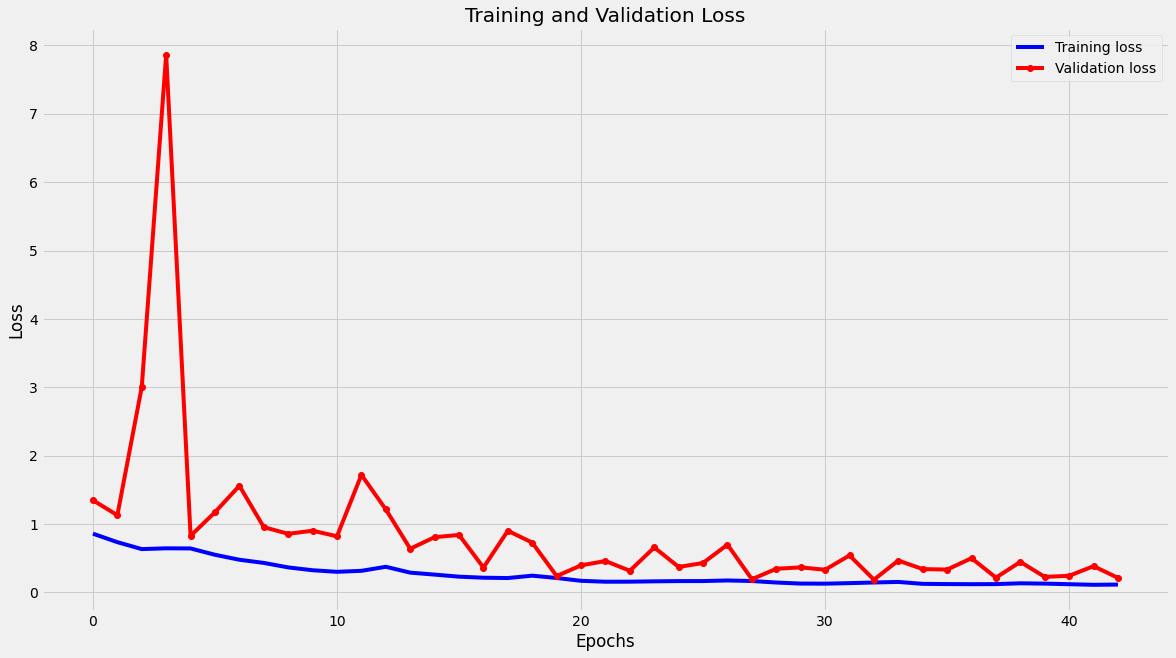

In [19]:
utils.plot_training(history, "Training and Validation Loss")

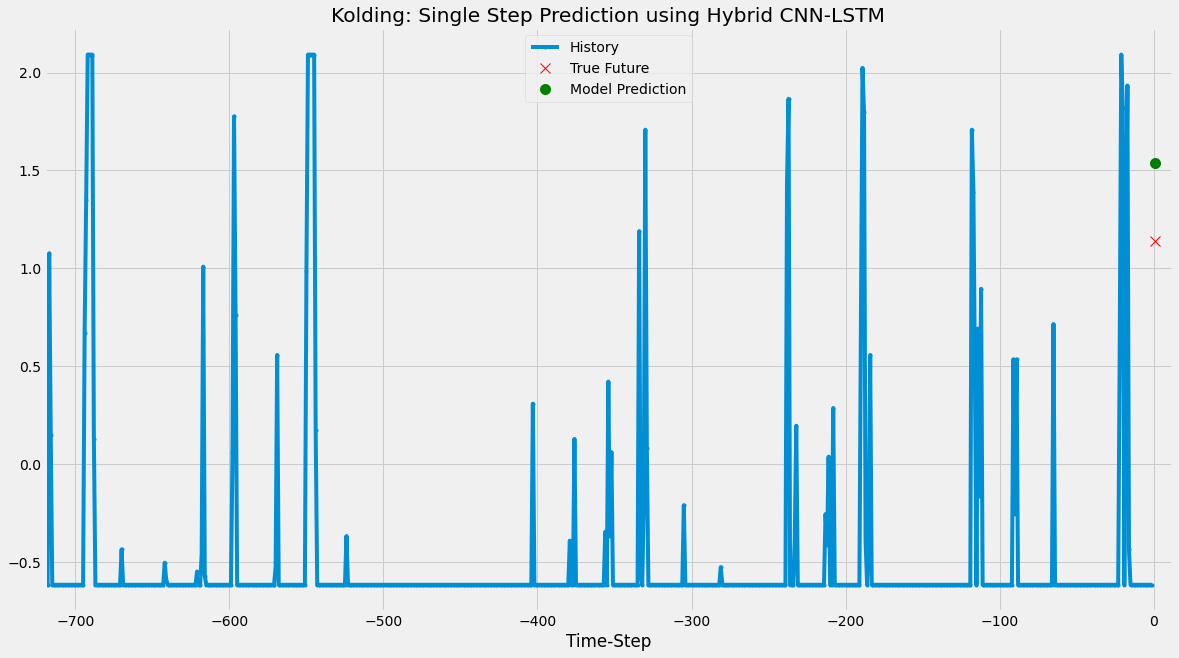

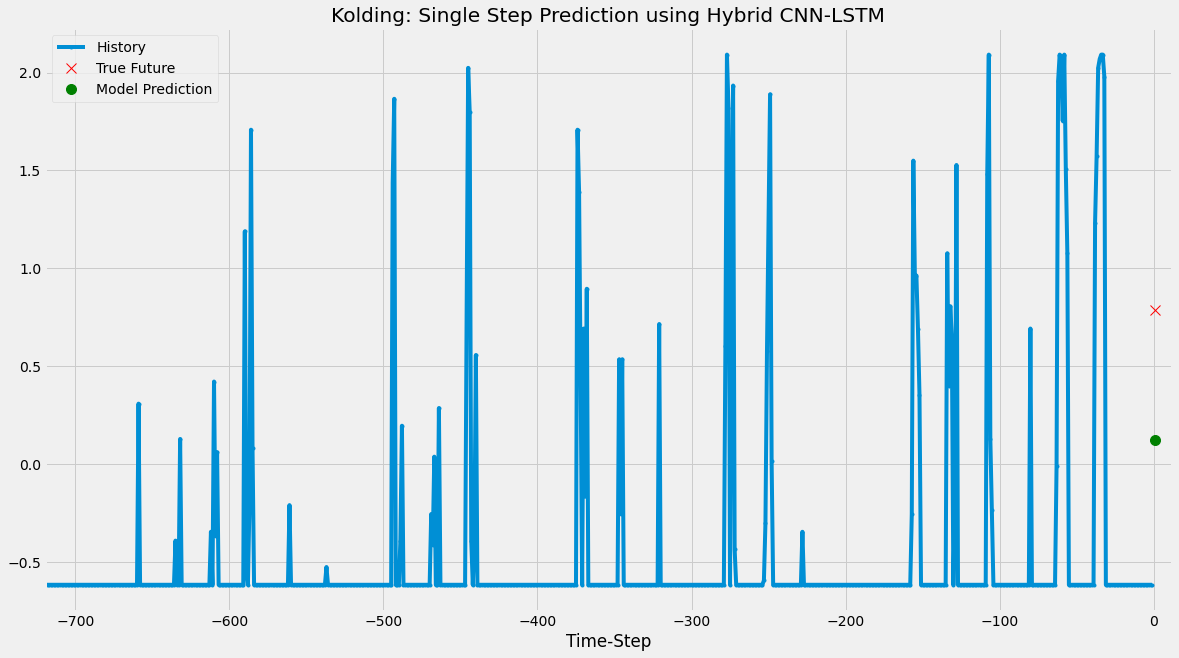

In [20]:
# Predictions
for x, y in kld_test.take(5):
    utils.plot_pred(
        [x[0][:, 1].numpy(), y[0].numpy(), hybrid.predict(x)[0]],
        1,
        "Kolding: Single Step Prediction using Hybrid CNN-LSTM",
    )


#### Without weekend and quarter features

In [7]:
# Processing Parameters
split = 0.80 # split percentage for training data
steps = 1 # timesteps: 1 hour

lookback = 24 * 30 # the number of hours in the past the model is shown
horizon = 1 # the target hour in the future we want to predict 1 hour ahead

# Training parameters
batch_size = 256
epochs = 50
lr = 0.001

In [8]:
# without weekend and quarter features
kld = kld[['Value', 'sunshine_mins', 'airtemp_c', 'daylength_hrs', 'wkdy_sin','wkdy_cos']]
stb = stb[['Value', 'sunshine_mins', 'airtemp_c', 'daylength_hrs', 'wkdy_sin','wkdy_cos']]

# Create Train, Val, and Test Sets
kld_train, kld_val, kld_test = processing.create_datasets(kld, split=split, steps=steps, lookback=lookback,
                                                          horizon=horizon, batch_size=batch_size, scaler='standard')
stb_train, stb_val, stb_test = processing.create_datasets(stb, split=split, steps=steps, lookback=lookback,
                                                          horizon=horizon, batch_size=batch_size, scaler='standard')

In [9]:
for batch in kld_train.take(1):
    inputs, targets = batch
    
print(f"Input Shape: {inputs.numpy().shape}")
print(f"Target Shape: {targets.numpy().shape}")

Input Shape: (256, 720, 6)
Target Shape: (256, 1)


In [11]:
hybrid = Sequential()

hybrid.add(Input(shape=(inputs.shape[1], inputs.shape[2])))

hybrid.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
hybrid.add(MaxPooling1D(pool_size=2))
hybrid.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
hybrid.add(MaxPooling1D(pool_size=2))

hybrid.add(LSTM(64, return_sequences=False))
hybrid.add(Dropout(0.25))

hybrid.add(Dense(1))

hybrid.compile(optimizer=Adam(learning_rate=lr), loss="mse", metrics=['mae'])

In [12]:
# Callbacks
ckpt_path = "../model/models/hybrid_few_feats.h5"
estp = EarlyStopping(monitor='val_loss', patience=10)

ckpt = ModelCheckpoint(
    monitor='val_loss',
    filepath=ckpt_path,
    verbose=1,
    save_weights_only=True,
    save_best_only=True
)

In [13]:
history = hybrid.fit(
    kld_train,
    epochs=epochs,
    validation_data=kld_val,
    callbacks=[estp, ckpt]
)

Epoch 1/50
57/57 [==============================] - 25s 400ms/step - loss: 0.9346 - mae: 0.7491 - val_loss: 1.3448 - val_mae: 0.9187

Epoch 00001: val_loss improved from inf to 1.34482, saving model to ../model/models\hybrid_few_feats.h5
Epoch 2/50
57/57 [==============================] - 21s 369ms/step - loss: 0.7902 - mae: 0.6907 - val_loss: 1.3726 - val_mae: 1.0379

Epoch 00002: val_loss did not improve from 1.34482
Epoch 3/50
57/57 [==============================] - 21s 373ms/step - loss: 0.8071 - mae: 0.7006 - val_loss: 1.2355 - val_mae: 0.9426

Epoch 00003: val_loss improved from 1.34482 to 1.23550, saving model to ../model/models\hybrid_few_feats.h5
Epoch 4/50
57/57 [==============================] - 23s 396ms/step - loss: 0.6780 - mae: 0.6411 - val_loss: 1.0627 - val_mae: 0.8629

Epoch 00004: val_loss improved from 1.23550 to 1.06266, saving model to ../model/models\hybrid_few_feats.h5
Epoch 5/50
57/57 [==============================] - 22s 383ms/step - loss: 0.5935 - mae: 0.59

57/57 [==============================] - 20s 353ms/step - loss: 0.1381 - mae: 0.2864 - val_loss: 0.3658 - val_mae: 0.5284

Epoch 00041: val_loss did not improve from 0.27184
Epoch 42/50
57/57 [==============================] - 20s 354ms/step - loss: 0.1204 - mae: 0.2700 - val_loss: 0.2176 - val_mae: 0.3941

Epoch 00042: val_loss improved from 0.27184 to 0.21760, saving model to ../model/models\hybrid_few_feats.h5
Epoch 43/50
57/57 [==============================] - 20s 353ms/step - loss: 0.1191 - mae: 0.2693 - val_loss: 0.2637 - val_mae: 0.4456

Epoch 00043: val_loss did not improve from 0.21760
Epoch 44/50
57/57 [==============================] - 20s 353ms/step - loss: 0.1167 - mae: 0.2662 - val_loss: 0.2144 - val_mae: 0.3985

Epoch 00044: val_loss improved from 0.21760 to 0.21444, saving model to ../model/models\hybrid_few_feats.h5
Epoch 45/50
57/57 [==============================] - 20s 354ms/step - loss: 0.1319 - mae: 0.2821 - val_loss: 0.2728 - val_mae: 0.4541

Epoch 00045: val_lo

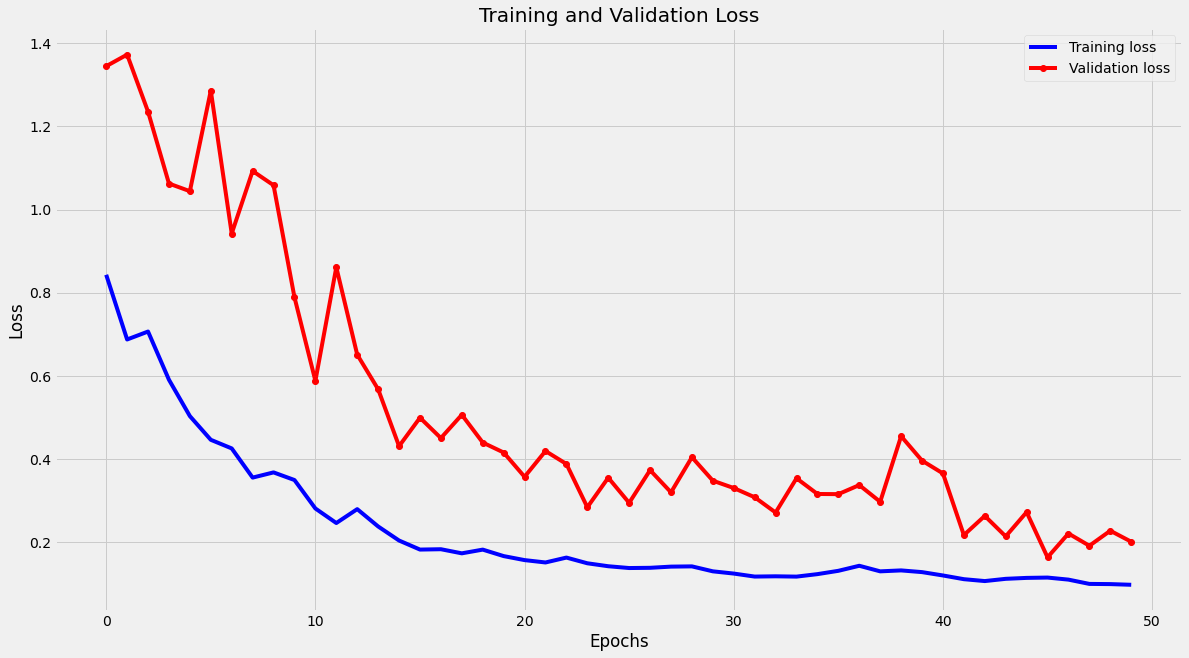

In [14]:
utils.plot_training(history, "Training and Validation Loss")

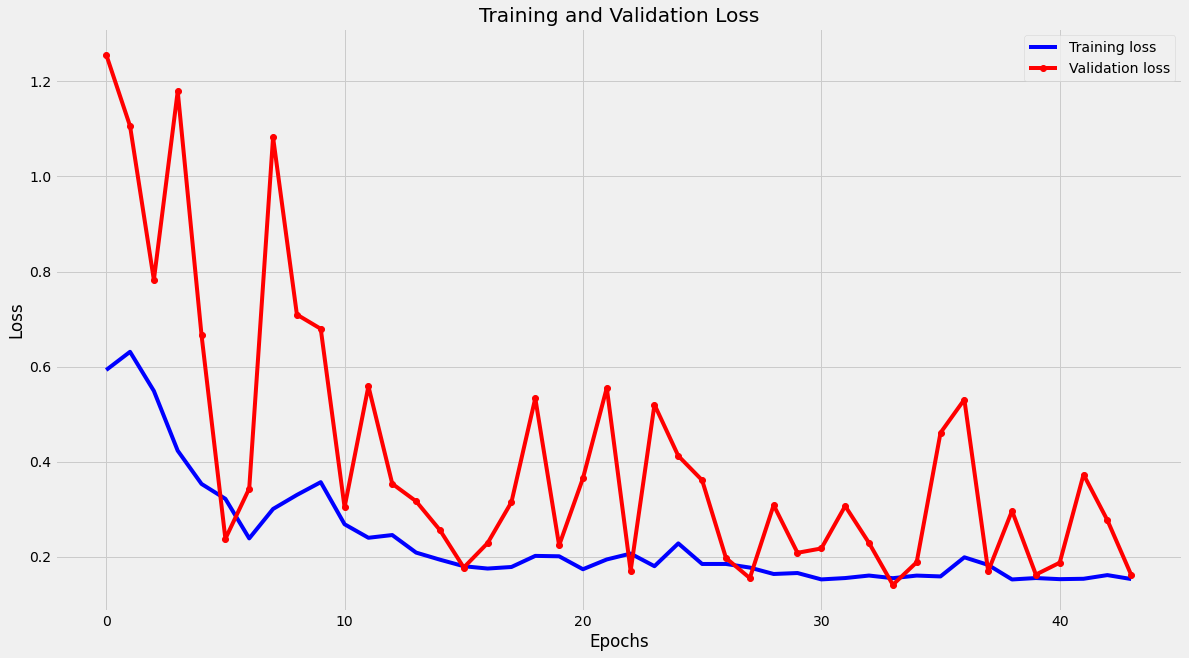

In [19]:
utils.plot_training(history, "Training and Validation Loss")